# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [ ]:
!pip install monai
# !python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 31.4 MB/s 


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 28.4 MB/s 
     |████████████████████████████████| 145 kB 65.8 MB/s 
     |████████████████████████████████| 181 kB 68.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ef6b8130c060398521b201e32c268a6808c16d9468a9e0060f25cef26d3bc16d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import monai
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
#https://docs.monai.io/en/stable/networks.html#nets for all available networks
#For detailed overview of models for classification, segmentation etc. go to
#https://pytorch.org/vision/stable/models.html#classification
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism
import time
import wandb

wandb.init(project="monai", entity="nsourlos",name="monai_2D_classification")

%matplotlib inline
print_config()

wandb: Currently logged in as: nsourlos. Use `wandb login --relogin` to force relogin


MONAI version: 0.9.0
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory=os.getcwd()
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [ ]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    #https://docs.monai.io/en/stable/apps.html for parameters of above function

MedNIST.tar.gz: 59.0MB [00:00, 89.1MB/s]                           

2022-06-19 08:40:29,095 - INFO - Downloaded: /content/MedNIST.tar.gz


2022-06-19 08:40:29,384 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-06-19 08:40:29,390 - INFO - Writing into directory: /content.


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x))) #name of classes taken from the folder names
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
] #path of each image - len(num_class) lists, each containing all paths for specific class
num_each = [len(image_files[i]) for i in range(num_class)]

image_files_list = []
image_class = []
for i in range(num_class): #Convert list of lists to list and do the same for their classes
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size #Assuming all images have the same dimension

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

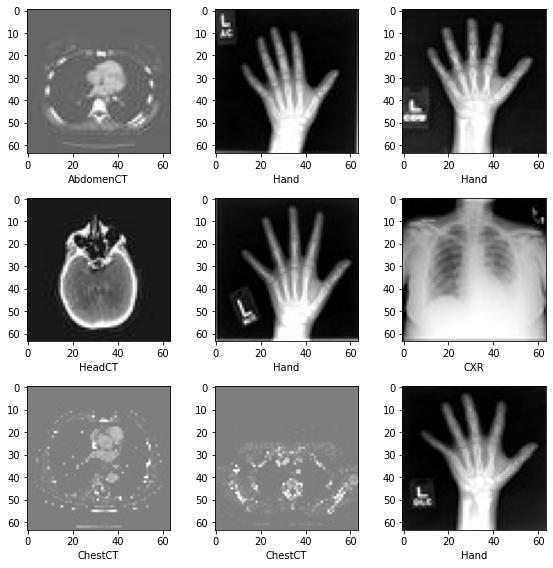

In [ ]:
fig,ax=plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    wandb.log({"img": [wandb.Image(im, caption=class_names[image_class[k]])]})

plt.tight_layout() #Otherwise x-axis names may not be shown
plt.show()

wandb.log({"plot combine": fig})

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test (can also be done with train_test_split function). 

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
#List of transforms here: https://docs.monai.io/en/stable/transforms.html
train_transforms = Compose( #Apply the following transforms in sequential order
    [ 
        LoadImage(image_only=True), #if True return only the image volume, otherwise return image data array and header dict.
        AddChannel(), #Converts an image into a channel-first format
        ScaleIntensity(), #NOT CLEAR, kind of normalization - Scale the intensity of input image to the given value range 
        #(minv, maxv). If minv and maxv not provided, use factor to scale image by v = v * (1 + factor).
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), #Range of rotation angle in radians, Probability of rotation,
        #and keep_size if True, the output shape is the same as the input.
        RandFlip(spatial_axis=0, prob=0.5), #Randomly flips the image along axes. Preserves shape
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5), #Randomly zooms input arrays within given zoom range.
        EnsureType(), #Ensure the input data to be a PyTorch Tensor
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

#Not same transforms as above since only used to extract validation batches info! (decollate_batch)
#For test set the validation transforms are applied below (test_ds and test_loader)
y_pred_trans = Compose([EnsureType(), Activations(softmax=True)]) #Add activation operations to the model output
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)]) 
#Execute after model forward to transform model output to discrete values. 
#convert input data into the one-hot format with specified number of classes.

In [ ]:
#All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite __getitem__(),
#supporting fetching a data sample for a given key. Subclasses could also optionally overwrite __len__(), which is expected to
#return the size of the dataset by many Sampler implementations and the default options of DataLoader.
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True,num_workers=2) #first argument must be a dataset - THIS IS WHY ABOVE CLASS??
#shuffle to have the data reshuffled at every epoch  
#num_workers=2 only in colab. num_workers=10 does not work locally! should be 0 to work. problem with parallel work. Check also (not fixed): 
#https://github.com/pytorch/pytorch/issues/51344
val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300,num_workers=2) #num_workers=10

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300,num_workers=2) #num_workers=10

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

Define sweeps and parameters over which experiments will run

In [ ]:
sweep_config = {
    'method': 'random' #'grid' if we want to take n sweeps in order (starting from the first parameters in dictionary below)
    }

In [ ]:
metric = {
    'name': 'epoch_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'max_epochs': {
        'values': [4,6,8,10]
        },
    'lr': {
        'values': [1e-5,1e-6,1e-4]
        }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
# parameters_dict.update({
#     'optimizer': {
#         'values': ['adam']
#     }) #If we want to add additional parameters

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="monai_2D_classification_sweeps_random")

Create sweep with ID: pg2eqeav
Sweep URL: https://wandb.ai/nsourlos/monai_sweeps_random/sweeps/pg2eqeav


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on {}".format(device))
#https://docs.monai.io/en/stable/networks.html#densenet for parameters
model = DenseNet121(spatial_dims=2, in_channels=1, #DenseNet121 with optional pretrained support when spatial_dims is 2.
                    out_channels=num_class).to(device) 
loss_function = torch.nn.CrossEntropyLoss()

#If wandb not used activate below
# optimizer = torch.optim.Adam(model.parameters(), 1e-5) #iterable of parameters to optimize or dicts defining parameter groups
# max_epochs = 4

val_interval = 1
auc_metric = ROCAUCMetric()

Training on cuda


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
%wandb #To initialize an interactive wandb window to see live progress in here

start=time.time()

#The following lines needed to run the sweeps - Training needs to be called from a function
def train(config=None):

  with wandb.init(config=config):

      config = wandb.config #The config file with the parameters

      optimizer = torch.optim.Adam(model.parameters(), config.lr) #iterable of parameters to optimize or dicts defining parameter groups
      max_epochs = config.max_epochs

      best_metric = -1
      best_metric_epoch = -1
      epoch_loss_values = []
      metric_values = []

      for epoch in range(max_epochs):
          print("-" * 10)
          print(f"epoch {epoch + 1}/{max_epochs}")
          model.train()
          epoch_loss = 0
          step = 0

          # Optional - Adds gradients and parameters
          # wandb.watch(model,log_freq=1) # log="all", freq was 10
          
          for batch_data in train_loader: 
              step += 1
              inputs, labels = batch_data[0].to(device), batch_data[1].to(device) #Inputs and labels for first batch
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = loss_function(outputs, labels)
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()

              wandb.log({"train_loss": loss.item()}) #Update training loss in wandb

              print(
                  f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
              epoch_len = len(train_ds) // train_loader.batch_size
          epoch_loss /= step #since we have increased the loss in each step above
          epoch_loss_values.append(epoch_loss)
          print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
          
          wandb.log({"epoch_loss": epoch_loss,"epoch":epoch})

          if (epoch + 1) % val_interval == 0: #Validate after every epoch since val_interval=1
              model.eval()
              with torch.no_grad():
                  y_pred = torch.tensor([], dtype=torch.float32, device=device)
                  y = torch.tensor([], dtype=torch.long, device=device)
                  for val_data in val_loader:
                      val_images, val_labels = (
                          val_data[0].to(device),
                          val_data[1].to(device),
                      )
                      y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                      y = torch.cat([y, val_labels], dim=0)
                  #De-collate a batch of data (for example, as produced by a DataLoader).
                  #Images originally stored as (B,C,H,W,[D]) will be returned as (C,H,W,[D]). 
                  #https://docs.monai.io/en/stable/data.html
                  y_onehot = [y_trans(i) for i in decollate_batch(y)]
                  y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                  auc_metric(y_pred_act, y_onehot)
                  result = auc_metric.aggregate()

                  wandb.log({"auc_metric": result,"epoch":epoch})

                  auc_metric.reset()
                  del y_pred_act, y_onehot
                  metric_values.append(result)
                  acc_value = torch.eq(y_pred.argmax(dim=1), y) #Element-wise equity comparison
                  acc_metric = acc_value.sum().item() / len(acc_value)

                  wandb.log({"val_acc_metric": acc_metric,"epoch":epoch})

                  if result > best_metric:
                      best_metric = result
                      best_metric_epoch = epoch + 1
                      torch.save(model.state_dict(), os.path.join(
                          root_dir, "best_metric_model.pth"))
                      print("saved new best metric model")
                  print(
                      f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                      f" current accuracy: {acc_metric:.4f}"
                      f" best AUC: {best_metric:.4f}"
                      f" at epoch: {best_metric_epoch}"
                  )

      print(
          f"train completed, best_metric: {best_metric:.4f} "
          f"at epoch: {best_metric_epoch}")
      
wandb.agent(sweep_id, train, count=8) #Run 8 different experiments with random combinations of the parameters defined in the config file

end=time.time()
print("Training took {} secs".format(end-start)) #353 in local GPU and 259 in colab with num_workers=2, 3189 in local CPU - epochs=4 in all.

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 8n9yv46b with config:
wandb: 	lr: 1e-06
wandb: 	max_epochs: 6


----------
epoch 1/6
1/157, train_loss: 1.7888
2/157, train_loss: 1.7787
3/157, train_loss: 1.7888
4/157, train_loss: 1.7821
5/157, train_loss: 1.7819
6/157, train_loss: 1.7732
7/157, train_loss: 1.7723
8/157, train_loss: 1.7619
9/157, train_loss: 1.7764
10/157, train_loss: 1.7873
11/157, train_loss: 1.7422
12/157, train_loss: 1.7493
13/157, train_loss: 1.7611
14/157, train_loss: 1.7520
15/157, train_loss: 1.7483
16/157, train_loss: 1.7557
17/157, train_loss: 1.7322
18/157, train_loss: 1.7479
19/157, train_loss: 1.7398
20/157, train_loss: 1.7373
21/157, train_loss: 1.7368
22/157, train_loss: 1.7330
23/157, train_loss: 1.7239
24/157, train_loss: 1.7206
25/157, train_loss: 1.7166
26/157, train_loss: 1.7206
27/157, train_loss: 1.7262
28/157, train_loss: 1.7332
29/157, train_loss: 1.7002
30/157, train_loss: 1.7338
31/157, train_loss: 1.7077
32/157, train_loss: 1.7067
33/157, train_loss: 1.6918
34/157, train_loss: 1.6705
35/157, train_loss: 1.6934
36/157, train_loss: 1.6915
37/157, train_lo

auc_metric,▁▆▇▇██
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
epoch_loss,█▆▄▃▂▁
train_loss,██▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc_metric,▁▆▇▇██
auc_metric,0.99453
epoch,5
epoch_loss,0.51914
train_loss,0.41269
val_acc_metric,0.943


wandb: Agent Starting Run: a0gguuyj with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 4


----------
epoch 1/4
1/157, train_loss: 0.4342
2/157, train_loss: 0.4039
3/157, train_loss: 0.3392
4/157, train_loss: 0.3029
5/157, train_loss: 0.2382
6/157, train_loss: 0.1730
7/157, train_loss: 0.1920
8/157, train_loss: 0.1438
9/157, train_loss: 0.1139
10/157, train_loss: 0.0998
11/157, train_loss: 0.1418
12/157, train_loss: 0.0941
13/157, train_loss: 0.0964
14/157, train_loss: 0.1083
15/157, train_loss: 0.0741
16/157, train_loss: 0.0786
17/157, train_loss: 0.0422
18/157, train_loss: 0.0759
19/157, train_loss: 0.0563
20/157, train_loss: 0.0695
21/157, train_loss: 0.0636
22/157, train_loss: 0.0570
23/157, train_loss: 0.0301
24/157, train_loss: 0.0688
25/157, train_loss: 0.0360
26/157, train_loss: 0.0451
27/157, train_loss: 0.0270
28/157, train_loss: 0.0320
29/157, train_loss: 0.0413
30/157, train_loss: 0.0266
31/157, train_loss: 0.0278
32/157, train_loss: 0.0499
33/157, train_loss: 0.0470
34/157, train_loss: 0.0218
35/157, train_loss: 0.0291
36/157, train_loss: 0.0233
37/157, train_lo

auc_metric,▁██▇
epoch,▁▁▁▃▃▃▆▆▆███
epoch_loss,█▁▁▁
train_loss,█▄▃▂▂▂▃▂▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_acc_metric,▁█▇▇
auc_metric,1.0
epoch,3
epoch_loss,0.00379
train_loss,0.01754
val_acc_metric,0.99966


wandb: Agent Starting Run: rgu2b7wk with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 4


----------
epoch 1/4
1/157, train_loss: 0.0004
2/157, train_loss: 0.0011
3/157, train_loss: 0.0004
4/157, train_loss: 0.0004
5/157, train_loss: 0.0004
6/157, train_loss: 0.0011
7/157, train_loss: 0.0004
8/157, train_loss: 0.0004
9/157, train_loss: 0.0067
10/157, train_loss: 0.0015
11/157, train_loss: 0.0002
12/157, train_loss: 0.0011
13/157, train_loss: 0.0004
14/157, train_loss: 0.0230
15/157, train_loss: 0.0006
16/157, train_loss: 0.0006
17/157, train_loss: 0.0003
18/157, train_loss: 0.0006
19/157, train_loss: 0.0002
20/157, train_loss: 0.0003
21/157, train_loss: 0.0015
22/157, train_loss: 0.0001
23/157, train_loss: 0.0004
24/157, train_loss: 0.0024
25/157, train_loss: 0.0003
26/157, train_loss: 0.0003
27/157, train_loss: 0.0002
28/157, train_loss: 0.0003
29/157, train_loss: 0.0005
30/157, train_loss: 0.0545
31/157, train_loss: 0.0002
32/157, train_loss: 0.0013
33/157, train_loss: 0.0004
34/157, train_loss: 0.0006
35/157, train_loss: 0.0075
36/157, train_loss: 0.0061
37/157, train_lo

auc_metric,█▁██
epoch,▁▁▁▃▃▃▆▆▆███
epoch_loss,█▃▂▁
train_loss,▁▂▁▁█▃▁▁▂▁▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▁▁
val_acc_metric,▁▁▁█
auc_metric,1.0
epoch,3
epoch_loss,0.00114
train_loss,5e-05
val_acc_metric,1.0


wandb: Agent Starting Run: m78dieg6 with config:
wandb: 	lr: 0.0001
wandb: 	max_epochs: 4


----------
epoch 1/4
1/157, train_loss: 0.0002
2/157, train_loss: 0.0003
3/157, train_loss: 0.0001
4/157, train_loss: 0.0001
5/157, train_loss: 0.0009
6/157, train_loss: 0.0001
7/157, train_loss: 0.0100
8/157, train_loss: 0.0001
9/157, train_loss: 0.0003
10/157, train_loss: 0.0001
11/157, train_loss: 0.0002
12/157, train_loss: 0.0000
13/157, train_loss: 0.0000
14/157, train_loss: 0.0000
15/157, train_loss: 0.0003
16/157, train_loss: 0.0063
17/157, train_loss: 0.0014
18/157, train_loss: 0.0001
19/157, train_loss: 0.0002
20/157, train_loss: 0.0002
21/157, train_loss: 0.0001
22/157, train_loss: 0.0025
23/157, train_loss: 0.0014
24/157, train_loss: 0.0000
25/157, train_loss: 0.0000
26/157, train_loss: 0.0003
27/157, train_loss: 0.0001
28/157, train_loss: 0.0525
29/157, train_loss: 0.0086
30/157, train_loss: 0.0004
31/157, train_loss: 0.0000
32/157, train_loss: 0.0000
33/157, train_loss: 0.0001
34/157, train_loss: 0.0003
35/157, train_loss: 0.0207
36/157, train_loss: 0.0014
37/157, train_lo

auc_metric,██▁█
epoch,▁▁▁▃▃▃▆▆▆███
epoch_loss,█▁▅▅
train_loss,▁▁▁▁▁▁▁▁▁▁▅▁▄▁▁▁▁▁▂▁▁▁▁▃▁▂▁▁▃█▁▁▂▁▂▂▁▁▁▁
val_acc_metric,▁█▁█
auc_metric,1.0
epoch,3
epoch_loss,0.0014
train_loss,4e-05
val_acc_metric,1.0


wandb: Agent Starting Run: 222kf221 with config:
wandb: 	lr: 1e-06
wandb: 	max_epochs: 6


----------
epoch 1/6
1/157, train_loss: 0.0000
2/157, train_loss: 0.0001
3/157, train_loss: 0.0017
4/157, train_loss: 0.0003
5/157, train_loss: 0.0001
6/157, train_loss: 0.0034
7/157, train_loss: 0.0002
8/157, train_loss: 0.0005
9/157, train_loss: 0.0002
10/157, train_loss: 0.0000
11/157, train_loss: 0.0000
12/157, train_loss: 0.0001
13/157, train_loss: 0.0000
14/157, train_loss: 0.0001
15/157, train_loss: 0.0070
16/157, train_loss: 0.0001
17/157, train_loss: 0.0003
18/157, train_loss: 0.0001
19/157, train_loss: 0.0008
20/157, train_loss: 0.0001
21/157, train_loss: 0.0000
22/157, train_loss: 0.0000
23/157, train_loss: 0.0001
24/157, train_loss: 0.0001
25/157, train_loss: 0.0000
26/157, train_loss: 0.0001
27/157, train_loss: 0.0001
28/157, train_loss: 0.0000
29/157, train_loss: 0.0001
30/157, train_loss: 0.0001
31/157, train_loss: 0.0008
32/157, train_loss: 0.0008
33/157, train_loss: 0.0000
34/157, train_loss: 0.0045
35/157, train_loss: 0.0000
36/157, train_loss: 0.0001
37/157, train_lo

auc_metric,▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
epoch_loss,▆▆█▃▃▁
train_loss,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃
val_acc_metric,▁▁▁▁▁▁
auc_metric,1.0
epoch,5
epoch_loss,0.00029
train_loss,0.00033
val_acc_metric,1.0


wandb: Agent Starting Run: 87zxuyfi with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 8


----------
epoch 1/8
1/157, train_loss: 0.0000
2/157, train_loss: 0.0000
3/157, train_loss: 0.0003
4/157, train_loss: 0.0000
5/157, train_loss: 0.0000
6/157, train_loss: 0.0000
7/157, train_loss: 0.0001
8/157, train_loss: 0.0000
9/157, train_loss: 0.0002
10/157, train_loss: 0.0001
11/157, train_loss: 0.0000
12/157, train_loss: 0.0000
13/157, train_loss: 0.0000
14/157, train_loss: 0.0001
15/157, train_loss: 0.0000
16/157, train_loss: 0.0000
17/157, train_loss: 0.0010
18/157, train_loss: 0.0001
19/157, train_loss: 0.0085
20/157, train_loss: 0.0005
21/157, train_loss: 0.0003
22/157, train_loss: 0.0025
23/157, train_loss: 0.0001
24/157, train_loss: 0.0000
25/157, train_loss: 0.0000
26/157, train_loss: 0.0000
27/157, train_loss: 0.0000
28/157, train_loss: 0.0000
29/157, train_loss: 0.0001
30/157, train_loss: 0.0001
31/157, train_loss: 0.0000
32/157, train_loss: 0.0000
33/157, train_loss: 0.0064
34/157, train_loss: 0.0001
35/157, train_loss: 0.0000
36/157, train_loss: 0.0003
37/157, train_lo

auc_metric,▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
epoch_loss,█▂▅▃▁▃▂▂
train_loss,▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_acc_metric,▁▁▁▁▁▁▁▁
auc_metric,1.0
epoch,7
epoch_loss,6e-05
train_loss,0.00092
val_acc_metric,1.0


wandb: Agent Starting Run: 3v7s8bwv with config:
wandb: 	lr: 1e-06
wandb: 	max_epochs: 4


----------
epoch 1/4
1/157, train_loss: 0.0000
2/157, train_loss: 0.0000
3/157, train_loss: 0.0000
4/157, train_loss: 0.0000
5/157, train_loss: 0.0000
6/157, train_loss: 0.0000
7/157, train_loss: 0.0000
8/157, train_loss: 0.0000
9/157, train_loss: 0.0000
10/157, train_loss: 0.0000
11/157, train_loss: 0.0000
12/157, train_loss: 0.0000
13/157, train_loss: 0.0000
14/157, train_loss: 0.0002
15/157, train_loss: 0.0000
16/157, train_loss: 0.0000
17/157, train_loss: 0.0000
18/157, train_loss: 0.0000
19/157, train_loss: 0.0000
20/157, train_loss: 0.0000
21/157, train_loss: 0.0000
22/157, train_loss: 0.0000
23/157, train_loss: 0.0000
24/157, train_loss: 0.0000
25/157, train_loss: 0.0000
26/157, train_loss: 0.0000
27/157, train_loss: 0.0000
28/157, train_loss: 0.0000
29/157, train_loss: 0.0000
30/157, train_loss: 0.0000
31/157, train_loss: 0.0000
32/157, train_loss: 0.0003
33/157, train_loss: 0.0000
34/157, train_loss: 0.0000
35/157, train_loss: 0.0000
36/157, train_loss: 0.0000
37/157, train_lo

auc_metric,▁▁▁▁
epoch,▁▁▁▃▃▃▆▆▆███
epoch_loss,▃▁█▆
train_loss,▁▁▁▁▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▃▁▁▇▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▂
val_acc_metric,▁▁▁▁
auc_metric,1.0
epoch,3
epoch_loss,5e-05
train_loss,4e-05
val_acc_metric,1.0


wandb: Agent Starting Run: 45u7nxoz with config:
wandb: 	lr: 1e-05
wandb: 	max_epochs: 6


----------
epoch 1/6
1/157, train_loss: 0.0000
2/157, train_loss: 0.0000
3/157, train_loss: 0.0000
4/157, train_loss: 0.0000
5/157, train_loss: 0.0000
6/157, train_loss: 0.0000
7/157, train_loss: 0.0000
8/157, train_loss: 0.0000
9/157, train_loss: 0.0000
10/157, train_loss: 0.0000
11/157, train_loss: 0.0000
12/157, train_loss: 0.0000
13/157, train_loss: 0.0000
14/157, train_loss: 0.0000
15/157, train_loss: 0.0001
16/157, train_loss: 0.0000
17/157, train_loss: 0.0000
18/157, train_loss: 0.0000
19/157, train_loss: 0.0000
20/157, train_loss: 0.0000
21/157, train_loss: 0.0000
22/157, train_loss: 0.0000
23/157, train_loss: 0.0000
24/157, train_loss: 0.0000
25/157, train_loss: 0.0000
26/157, train_loss: 0.0000
27/157, train_loss: 0.0000
28/157, train_loss: 0.0000
29/157, train_loss: 0.0000
30/157, train_loss: 0.0000
31/157, train_loss: 0.0000
32/157, train_loss: 0.0000
33/157, train_loss: 0.0000
34/157, train_loss: 0.0000
35/157, train_loss: 0.0000
36/157, train_loss: 0.0000
37/157, train_lo

auc_metric,▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▄▄▄▅▅▅▇▇▇███
epoch_loss,▂▁▅▁█▁
train_loss,▂▁▁▁▁▁▁█▁▂▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▃
val_acc_metric,▁▁▁▁▁▁
auc_metric,1.0
epoch,5
epoch_loss,2e-05
train_loss,0.0
val_acc_metric,1.0


Training took 2732.555186033249 secs


## Plot the loss and metric

In [ ]:
#Does not work when we use a config file for wandb

# fig=plt.figure("train", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Epoch Average Loss")
# x = [i + 1 for i in range(len(epoch_loss_values))]
# y = epoch_loss_values
# plt.xlabel("epoch")
# plt.plot(x, y)
# plt.subplot(1, 2, 2)
# plt.title("Val AUC")
# x = [val_interval * (i + 1) for i in range(len(metric_values))]
# y = metric_values
# plt.xlabel("epoch")
# plt.plot(x, y)
# plt.show()

# wandb.log({"plot combine": fig})

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

# Save the model in the exchangeable ONNX format
torch.onnx.export(model, test_images,"model.onnx")
wandb.init()
wandb.save("model.onnx")

['/content/wandb/run-20220619_093838-45u7nxoz/files/model.onnx']

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4)) #Check how to add that in wandb. It is a string.

              precision    recall  f1-score   support

   AbdomenCT     1.0000    1.0000    1.0000       995
   BreastMRI     1.0000    1.0000    1.0000       880
         CXR     1.0000    1.0000    1.0000       982
     ChestCT     1.0000    1.0000    1.0000      1014
        Hand     1.0000    1.0000    1.0000      1048
      HeadCT     1.0000    1.0000    1.0000       976

    accuracy                         1.0000      5895
   macro avg     1.0000    1.0000    1.0000      5895
weighted avg     1.0000    1.0000    1.0000      5895



## Cleanup data directory

In [ ]:
# shutil.rmtree(root_dir)

In [ ]:
wandb.finish()
